# 13.3 目标检测和边界框

In [ ]:
%matplotlib inline

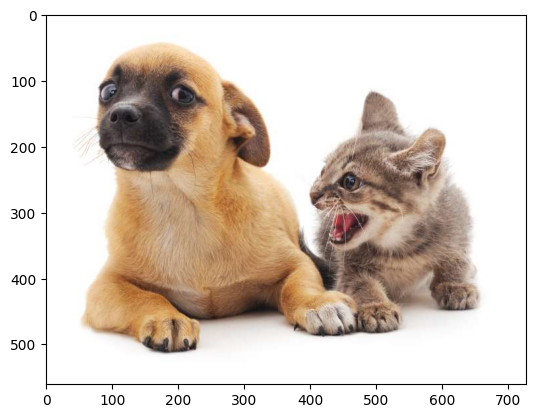

In [6]:
import matplotlib.pyplot as plt
import torch
img_path = '../../docs/img/catdog.jpg'
# read image
img = plt.imread(img_path)
# show image
plt.imshow(img)
plt.show()

## 13.3.1 边界框

边界框是矩形的， 由左上角和右下角的坐标 $(x_1, y_1)$ 和 $(x_2, y_2)$ 定义。 另一种常用的表示方法是边界框的中心点 $(c_x, c_y)$ 以及宽度 $w$ 和高度 $h$。 这两种表示方法可以相互转换

In [ ]:
def box_corner_to_center(boxes):
    """从(左上, 右下)格式转换到(中心, 宽度, 高度)格式
    boxes: 张量，形状为(..., 4)
    其中最后一个维度分别对应(x1, y1, x2, y2)
    返回: 张量，形状为(..., 4)
    其中最后一个维度分别对应(c_x, c_y, w, h)
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从(中心, 宽度, 高度)格式转换到(左上, 右下)格式
    boxes: 张量，形状为(..., 4)
    其中最后一个维度分别对应(c_x, c_y, w, h)
    返回: 张量，形状为(..., 4)
    其中最后一个维度分别对应(x1, y1, x2, y2)
    """
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

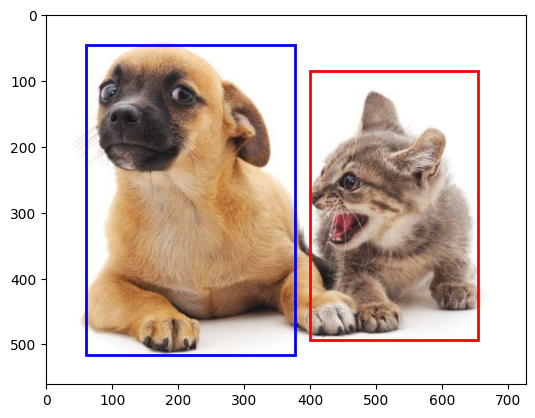

In [8]:
from matplotlib import patches
def bbox_to_rect(bbox, color):
    """将边界框(左上, 右下)格式转换成matplotlib格式的矩形
    bbox: 包含边界框的张量，形状为(4,)，
    其中最后一个维度分别对应(x1, y1, x2, y2)
    color: 矩形颜色
    返回: matplotlib格式的矩形
    """
    
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    return patches.Rectangle(
        (x1, y1), width, height,
        fill=False, edgecolor=color, linewidth=2
    )
dog_bbox = torch.tensor([60.0, 45.0, 378.0, 516.0])
cat_bbox = torch.tensor([400.0, 85.0, 655.0, 493.0])
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))
plt.show()

## Anchor (锚框)

目标检测算法 通常使用预定义的边界框集合， 称为锚框 (anchor boxes) 或先验框 (prior boxes)， 以检测图像中的对象。 这些锚框具有不同的大小和宽高比， 并且均匀地分布在图像上。 通过这种方式， 模型可以预测每个锚框是否包含对象以及对象的类别。

### 锚框的生成

假设输入图像的高度为$h$, 宽度为$w$。 我们以图像的每个像素为中心生成不同形状的锚框：缩放比为$s \in (0,1]$， 宽高比为 $r > 0$。 那么锚框的宽度和高度分别为 $hs\sqrt{r}$ 和 $hs/\sqrt{r}$。

要生成多个不同形状的的锚框，我们设置许多缩放比取值$s_1,...,s_n$和许多宽高比取值$r_1,...,r_m$。在实践中，我们只考虑包含$s_1$或$r_1$的组合：
$$
(s_1, r_1), (s_1, r_2), ..., (s_1, r_m), (s_2, r_1), (s_3, r_1),..., (s_n, r_1)
$$

也就是说，同一像素为中心的锚框的数量是$m + n - 1$。 如果我们在 $h \times w$ 个像素上生成锚框， 那么总的锚框数量为 $(m + n - 1)hw$。

In [16]:
def multibox_prior(data, sizes, ratios):
    """生成多尺度锚框
    data: 输入图像，形状为(批量大小, 通道数, 高度, 宽度)
    sizes: 锚框的尺寸列表
    ratios: 锚框的宽高比列表
    返回: 锚框，形状为(1, 高度*宽度*锚框数量, 4)
    其中最后一个维度分别对应(c_x, c_y, w, h)
    """
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # 计算锚框的宽度和高度
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width
    # 生成锚框的中心点坐标
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    #生成所有锚框
    # 之后用于创建锚框的四角坐标(x_min, y_min, x_max, y_max)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:]))) 
    # 除以2来获得宽度和高度的一半
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    out_grid = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [17]:
h, w = img.shape[:2]
print(f"height: {h}, width: {w}")
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
print(Y.shape)  # (1, 高度*宽度*锚框数量, 4)

height: 561, width: 728
torch.Size([1, 2042040, 4])


In [18]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """在图上绘制边界框
    axes: matplotlib的轴对象
    bboxes: 包含边界框的张量，形状为(边界框数量, 4)
    labels: 包含边界框标签的列表
    colors: 包含边界框颜色的列表
    """
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9,
                      color=text_color, bbox=dict(facecolor=color, lw=0))

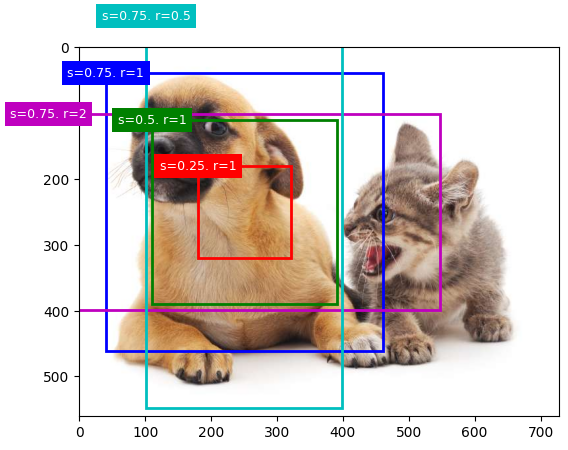

In [19]:
bbox_scale = torch.tensor((w, h, w, h))
boxes = Y.reshape(h, w, -1, 4)
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250,250,:,:] * bbox_scale,
            ['s=0.75. r=1', 's=0.5. r=1', 's=0.25. r=1',
             's=0.75. r=2', 's=0.75. r=0.5'])
plt.show()